# Model Evaluation and Analysis
This notebook loads predictions from all models (SARIMA, SIR, SEIR) and visualizes their performance.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure figure size
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [22]:
# Define paths
pred_dir = Path('../predictions')

# Load predictions
models = {}

# SARIMA
sarima_path = pred_dir / 'sarima_predictions.csv'
if sarima_path.exists():
    models['SARIMA'] = pd.read_csv(sarima_path)
    models['SARIMA']['date'] = pd.to_datetime(models['SARIMA']['date'])
    print(f"Loaded SARIMA predictions: {len(models['SARIMA'])} rows")
else:
    print(f"Warning: {sarima_path} not found")

# SIR
sir_path = pred_dir / 'sir_predictions.csv'
if sir_path.exists():
    models['SIR'] = pd.read_csv(sir_path)
    models['SIR']['date'] = pd.to_datetime(models['SIR']['date'])
    print(f"Loaded SIR predictions: {len(models['SIR'])} rows")
else:
    print(f"Warning: {sir_path} not found")

# SEIR
seir_path = pred_dir / 'seir_predictions.csv'
if seir_path.exists():
    models['SEIR'] = pd.read_csv(seir_path)
    models['SEIR']['date'] = pd.to_datetime(models['SEIR']['date'])
    print(f"Loaded SEIR predictions: {len(models['SEIR'])} rows")
else:
    print(f"Warning: {seir_path} not found")

print(f"\nTotal models loaded: {len(models)}")

Loaded SARIMA predictions: 319 rows
Loaded SIR predictions: 103 rows
Loaded SEIR predictions: 103 rows

Total models loaded: 3


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Calculate metrics for each model and region
regions = ['nat']
metrics_summary = []

for model_name, df in models.items():
    for region in regions:
        region_data = df[df['region'] == region]
        if len(region_data) > 0:
            metrics = calculate_metrics(
                region_data['true_ili'].values,
                region_data['predicted_ili'].values
            )
            metrics_summary.append({
                'Model': model_name,
                'Region': region,
                **metrics
            })

metrics_df = pd.DataFrame(metrics_summary)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
 Model Region     RMSE      MAE      MAPE        R2
SARIMA    nat 1.393798 0.996413 33.163045  0.299754
   SIR    nat 1.928789 1.499961 47.318560 -0.340975
  SEIR    nat 1.953067 1.515411 47.707718 -0.374945


### Regional PRedictions

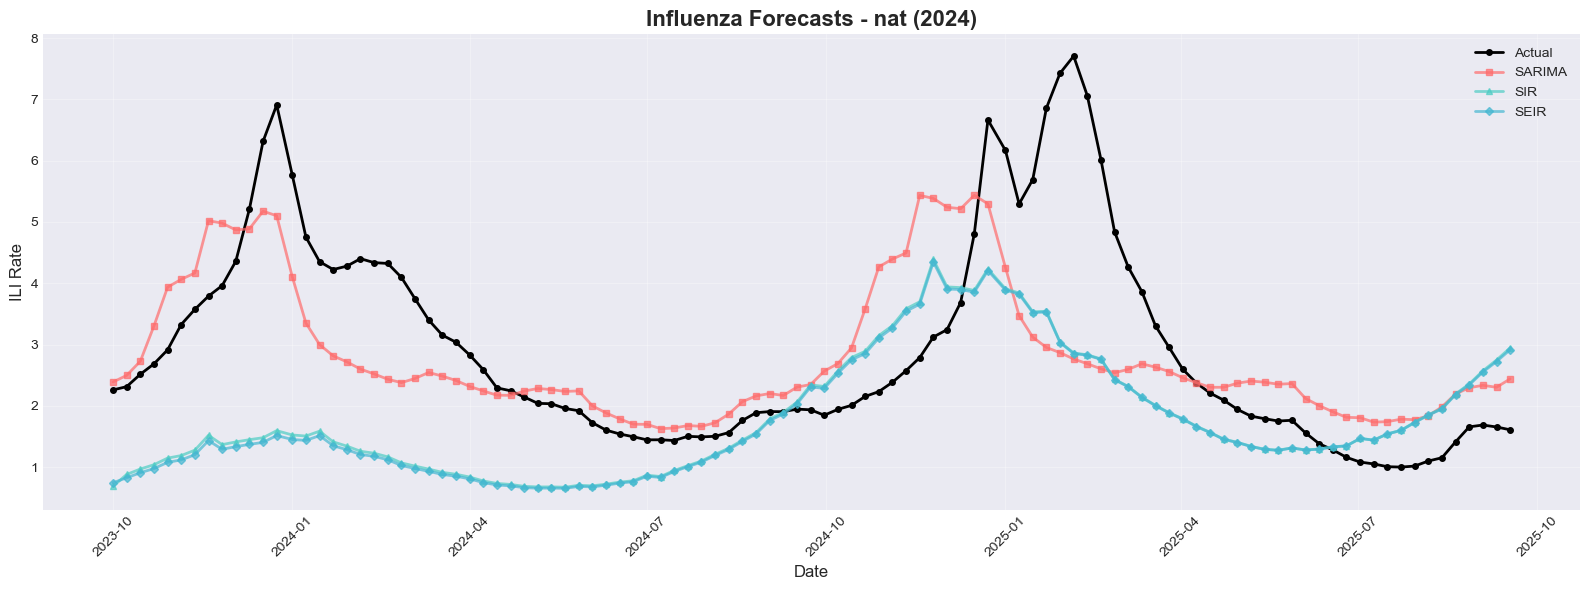

Plot saved: predictions/predictions_nat.png


In [24]:
# Plot predictions for each region
for region in regions:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Get actual values (from first available model)
    first_model = list(models.keys())[0]
    region_data = models[first_model][models[first_model]['region'] == region]
    
    if len(region_data) > 0:
        # Plot actual values
        ax.plot(region_data['date'], region_data['true_ili'], 
                'k-', linewidth=2, label='Actual', marker='o', markersize=4)
        
        # Plot predictions from each model
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        markers = ['s', '^', 'D']
        
        for idx, (model_name, df) in enumerate(models.items()):
            model_region_data = df[df['region'] == region]
            if len(model_region_data) > 0:
                ax.plot(model_region_data['date'], model_region_data['predicted_ili'],
                        linewidth=2, label=model_name, alpha=0.7,
                        marker=markers[idx % len(markers)], markersize=4,
                        color=colors[idx % len(colors)])
        
        ax.set_title(f'Influenza Forecasts - {region} (2024)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('ILI Rate', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'../predictions/predictions_{region}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plot saved: predictions/predictions_{region}.png")
    else:
        print(f"No data available for region: {region}")